## Installations (run all following installations chunks after taking out of comments if needed, this notebook was run without sudo access and under conda)

In [ ]:
# if you have sudo access, you can run this cell to install the dependencies
# %%capture
# !sudo add-apt-repository -y ppa:openjdk-r/ppa
# !sudo apt-get purge openjdk-*
# !sudo apt-get install openjdk-8-jdk
# !sudo apt-get install xvfb xserver-xephyr vnc4server python-opengl ffmpeg

In [ ]:
# if you are running on a server with no sudo access but with conda, you will need to run this cell instead.
# !conda install -y openjdk=8

In [ ]:
# run as needed
# %%capture
# !pip install --upgrade 'setuptools==57.5.0'
# !pip install 'gym==0.19.0'
# !pip install --upgrade wheel==0.38.4

In [ ]:
# run as needed
# %%capture
# !pip install --upgrade 'minerl==0.4.4'
# !pip install pyvirtualdisplay
# # !pip install pytorch
# !pip install scikit-learn
# !pip install -U colabgymrender
# !pip install pandas

## Imports

In [ ]:
import random
import numpy as np
import pandas as pd
import gym
import minerl
from tqdm.notebook import tqdm
from pyvirtualdisplay import Display
from sklearn.cluster import KMeans
import logging
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import pickle
import numpy as np
import time
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier

logging.disable(logging.ERROR) # reduce clutter, remove if something doesn't work to see the error logs.

In [ ]:
minerl.data.download(directory='data', environment='MineRLObtainIronPickaxe-v0');

In [ ]:
data=minerl.data.make("MineRLObtainIronPickaxe-v0")

## Create POV list

In [ ]:
povs = []
trajectories = data.get_trajectory_names()

for trajectoy in trajectories:
    data_gen = data.load_data(trajectoy, include_metadata=True)
    trajectoy_obs = []
    for idx, (obs, action, reward, next_obs, done, metadata) in enumerate(data_gen):
        
        trajectoy_obs.append(obs)

    for i, obs in enumerate(trajectoy_obs):
        povs.append(obs['pov'].flatten())

In [ ]:
filename = 'total_flattened_povs.pkl'

In [ ]:
# write pov list to pickle file
with open(filename, 'wb') as file:
    pickle.dump(povs, file)
del povs 
del trajectories

In [ ]:
# read pov list from pickle file
with open(filename, 'rb') as file:
    povs_data = pickle.load(file)

In [ ]:
x = len(povs_data) // 30000  # Calculate the step size ## change this to change the size of the data if you have more memory
povs_data_small = povs_data[::x]  # Create small-size data for clustering model
del povs_data
pickle.dump(povs_data_small, open("30K_povs_for_clustering", "wb"))

## Create Images Folder

In [ ]:
import os
from PIL import Image

# Specify the directory path
directory = '100K_images'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

for i, pov in enumerate(povs_data_small):
    # Convert the array to a Pillow image object
    image = Image.fromarray(pov)

    # Save the image as JPEG with a unique filename
    filename = f"img_{i}.jpg"
    image.save(os.path.join(directory, f'img_{i}.jpg'))

Memory usage: 500.22 MB


## DBSCAN + KNN

In [ ]:
# read reduced pov list from pickle file
with open('30K_povs_for_clustering', 'rb') as file:
    povs_data_small = pickle.load(file)

In [ ]:
start_time = time.time()
povs_array = np.vstack(povs_data_small)
del povs_data_small
data_normalized = povs_array / 255.0  # Normalize the pixel values to the range [0, 1]
del povs_array
print(f"Preprocess done in {time.time() - start_time} sec")

start_time = time.time()
epsilon = 10  # The maximum distance between two samples
min_samples = 10  # Specify the minimum number of samples required for a cluster
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')
dbscan.fit(data_normalized)
print(f"dbscan done in {time.time() - start_time} sec")

start_time = time.time()
# Create a KNN classifier object with k=50
knn = KNeighborsClassifier(n_neighbors=50)
# Train the KNN classifier object on the data points that have already been clustered
knn.fit(data_normalized, dbscan.labels_)
print(f"knn done in {time.time() - start_time} sec")

Preprocess done in 8.905370950698853 sec
dbscan done in 205.96250581741333 sec
knn done in 0.30640697479248047 sec


In [ ]:
import os
# Specify the directory path
directory = '30000pov_10eps_10min_50k'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save model1
with open(os.path.join(directory, 'DBSCAN_povs.pkl'), 'wb') as file:
    pickle.dump(dbscan, file)
    
# Save model2
with open(os.path.join(directory, 'KNN_povs.pkl'), 'wb') as file:
    pickle.dump(knn, file)

In [ ]:
def predict_pov_cluster(model, pov):
    """
    Predict cluster label of a single POV
    
    Args:        
        model: instance of the clustering model
        pov: 64*64*3 array
    """
    # Normalize the new pov
    pov_normalized = pov / 255.0  
    # Predict the label of the new pov
    label = model.predict(pov_normalized.reshape(1, -1))
    return label[0]

1

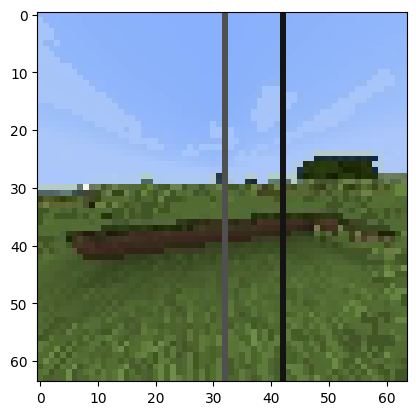

In [ ]:
pov1 = povs_data_small[1].reshape((64,64,3))
pov_c = pov1.copy()
for i in range(64):
    pov_c[i][32] = 80
    pov_c[i][42] = 20
plt.imshow(pov_c)
predict_pov_cluster(knn, pov_c)

Cluster -1: 12793 images
Cluster 0: 16469 images
Cluster 1: 13 images
Cluster 2: 41 images
Cluster 3: 11 images
Cluster 4: 13 images
Cluster 5: 14 images
Cluster 6: 41 images
Cluster 7: 11 images
Cluster 8: 12 images
Cluster 9: 15 images
Cluster 10: 13 images
Cluster 11: 104 images
Cluster 12: 12 images
Cluster 13: 12 images
Cluster 14: 14 images
Cluster 15: 12 images
Cluster 16: 10 images
Cluster 17: 17 images
Cluster 18: 15 images
Cluster 19: 12 images
Cluster 20: 10 images
Cluster 21: 10 images
Cluster 22: 16 images
Cluster 23: 16 images
Cluster 24: 14 images
Cluster 25: 11 images
Cluster 26: 12 images
Cluster 27: 38 images
Cluster 28: 11 images
Cluster 29: 15 images
Cluster 30: 12 images
Cluster 31: 15 images
Cluster 32: 25 images
Cluster 33: 18 images
Cluster 34: 16 images
Cluster 35: 14 images
Cluster 36: 12 images
Cluster 37: 10 images
Cluster 38: 12 images
Cluster 39: 13 images
Cluster 40: 10 images
Cluster 41: 13 images
Cluster 42: 11 images
Cluster 43: 10 images
Cluster 44: 1

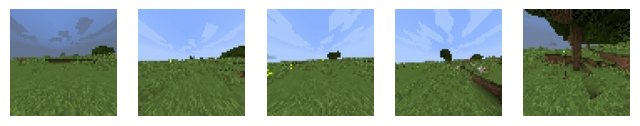

0


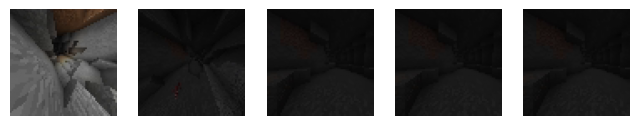

1


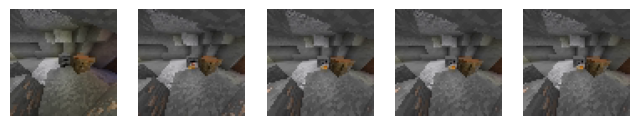

2


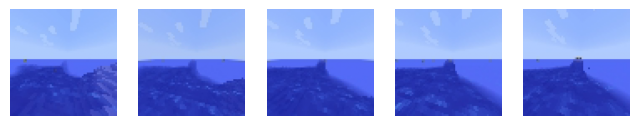

3


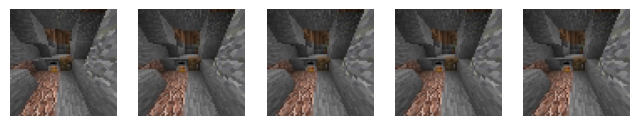

4


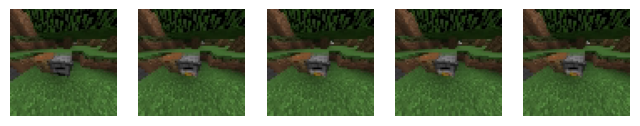

5


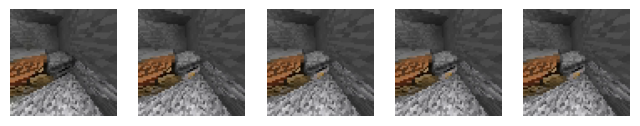

6


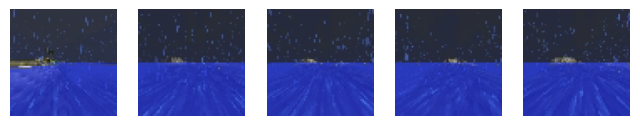

7


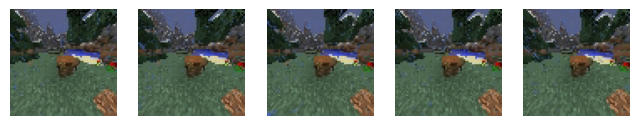

8


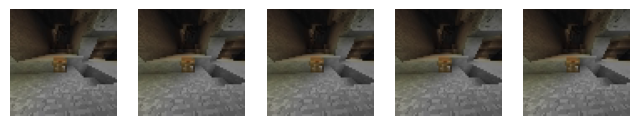

9


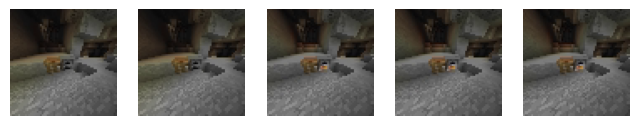

10


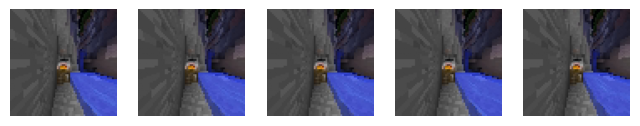

11


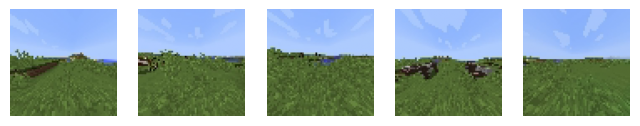

12


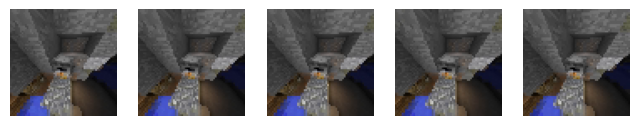

13


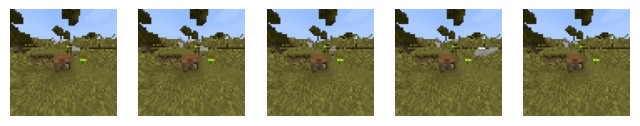

14


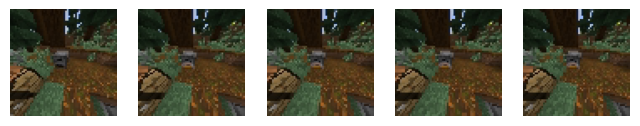

15


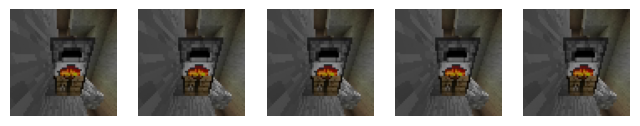

16


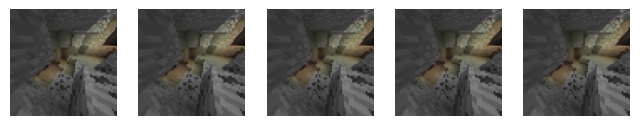

17


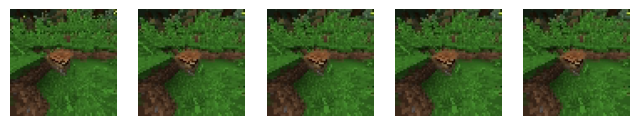

18


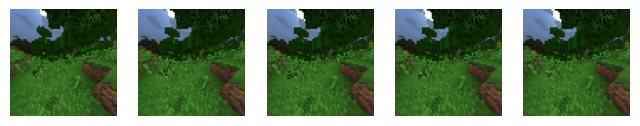

19


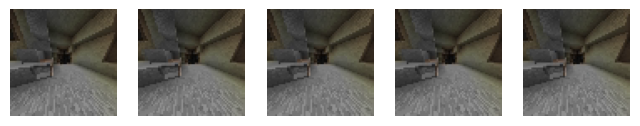

20


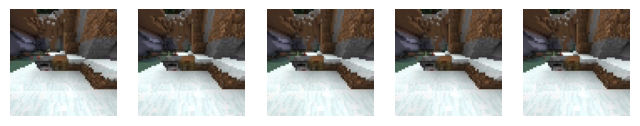

21


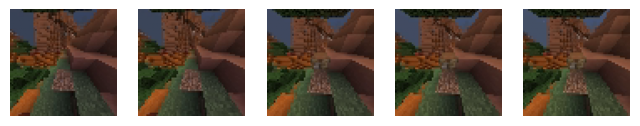

22


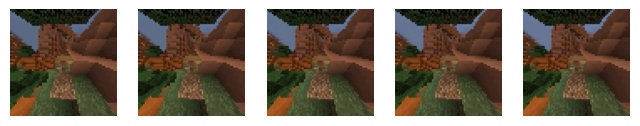

23


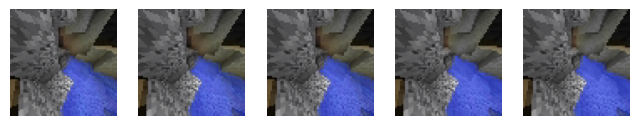

24


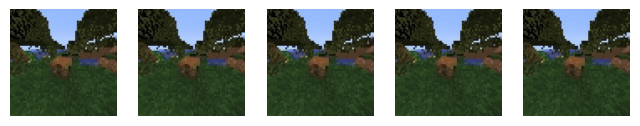

25


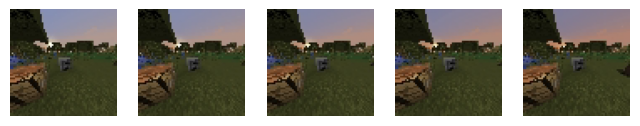

26


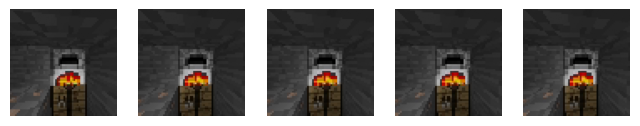

27


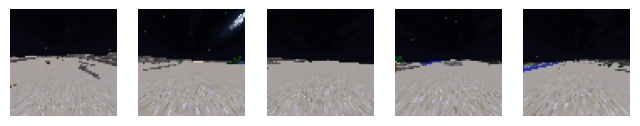

28


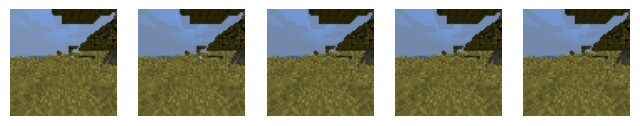

29


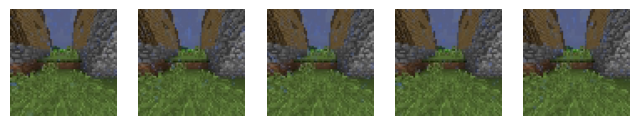

30


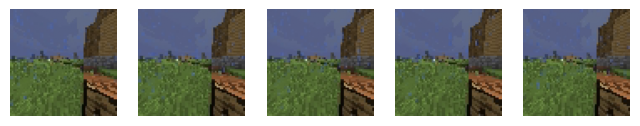

31


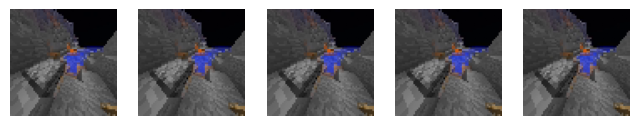

32


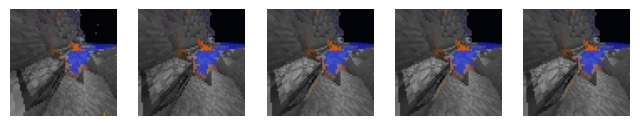

33


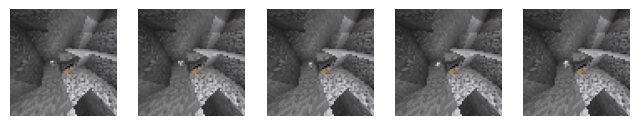

34


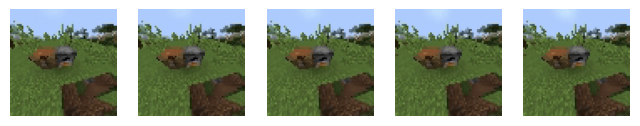

35


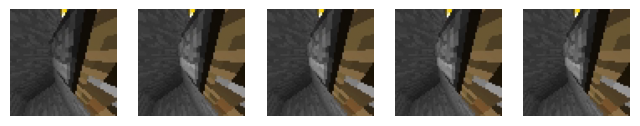

36


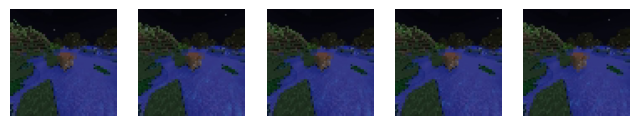

37


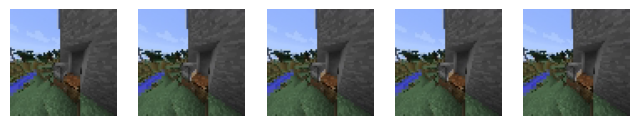

38


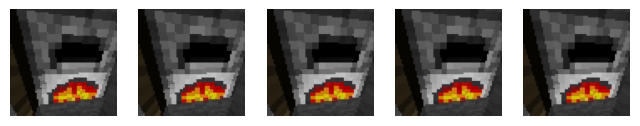

39


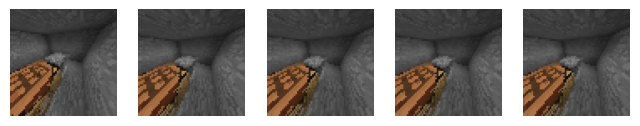

40


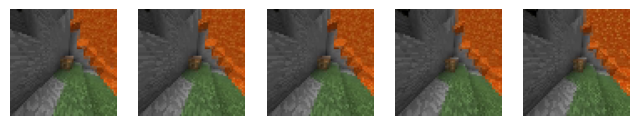

41


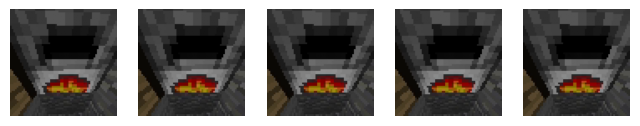

42


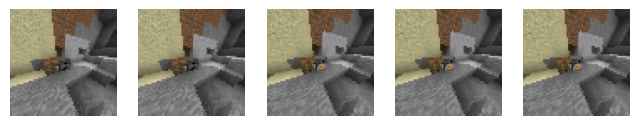

43


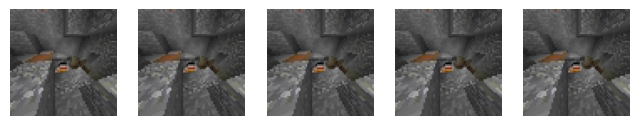

44


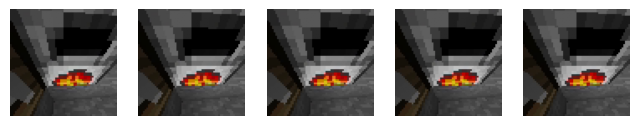

45


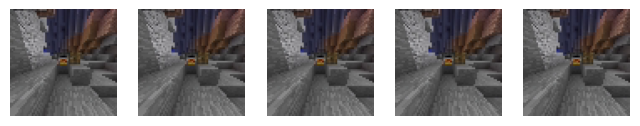

46


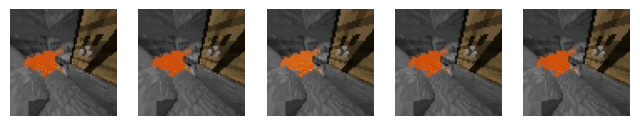

47


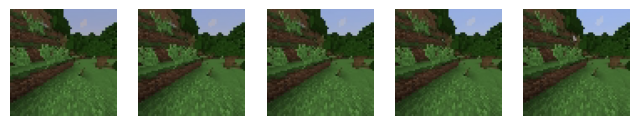

48


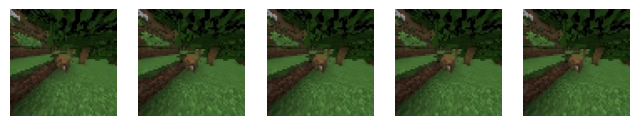

49


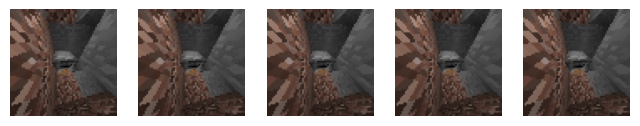

50


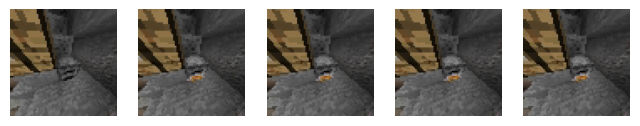

51


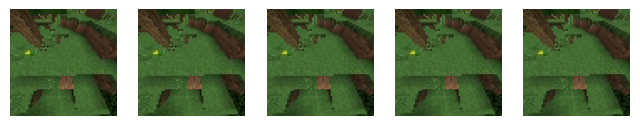

52


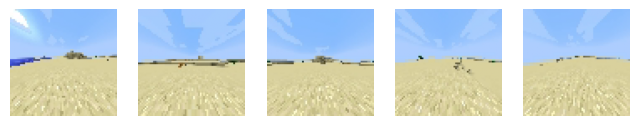

53


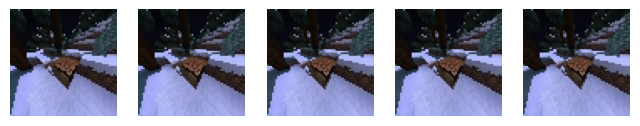

54


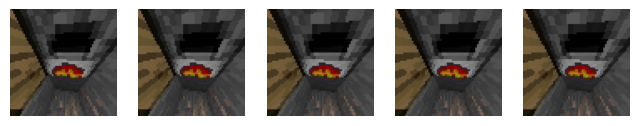

55


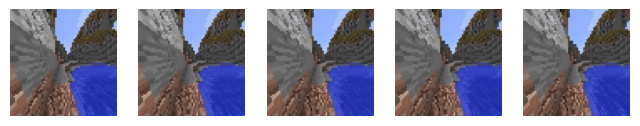

56


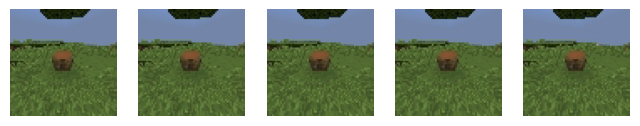

57


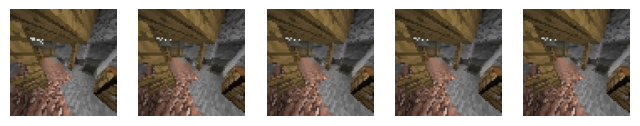

58


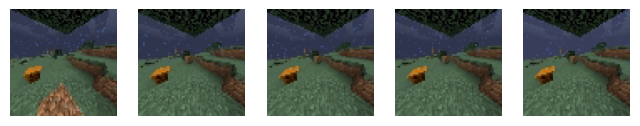

59


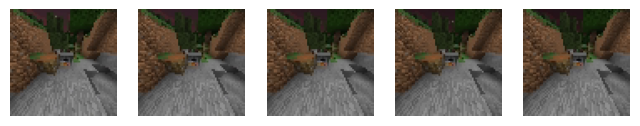

60


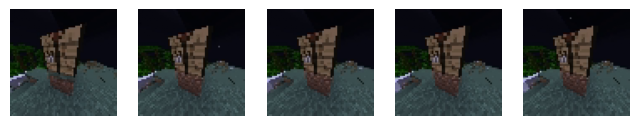

61


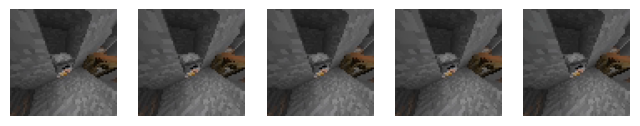

62


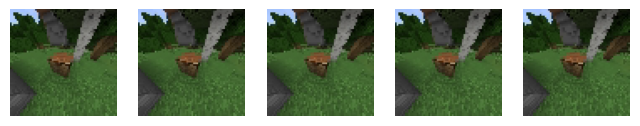

63


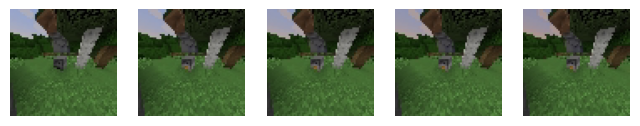

64


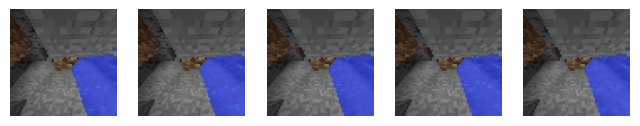

65


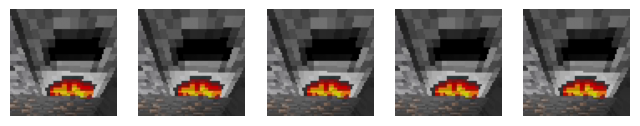

66


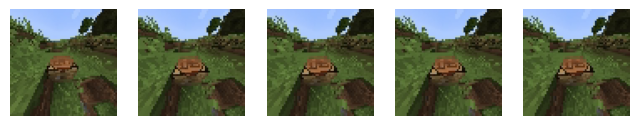

67


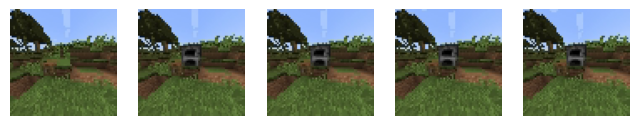

68


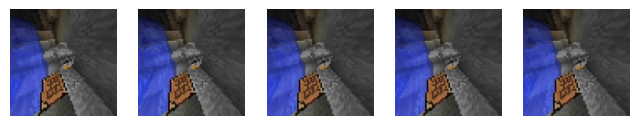

69


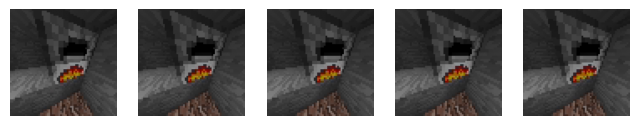

70


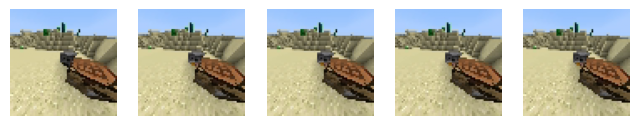

71


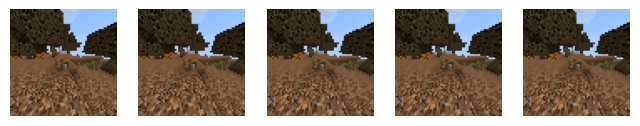

72


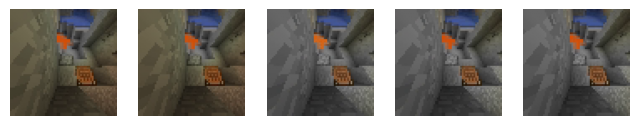

73


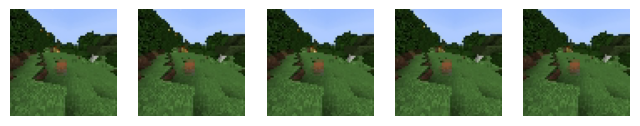

74


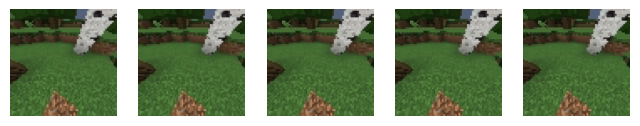

75


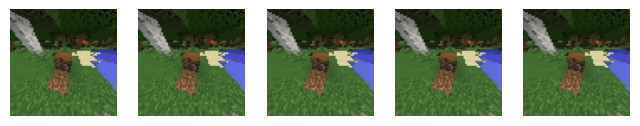

76


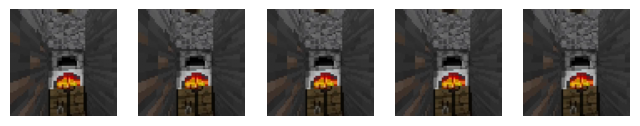

77


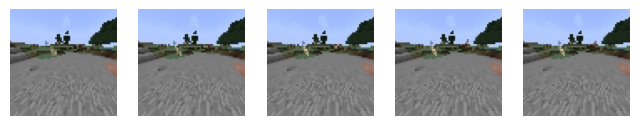

78


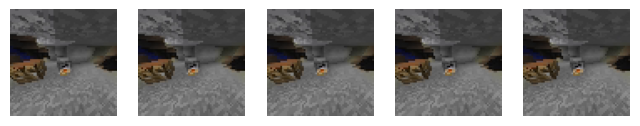

79


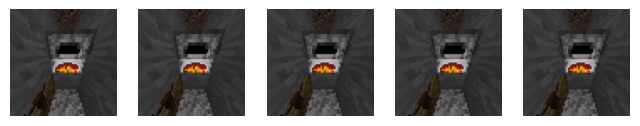

80


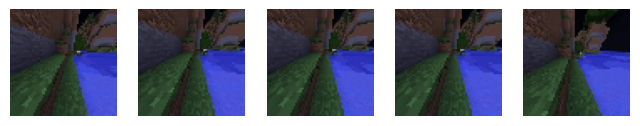

81


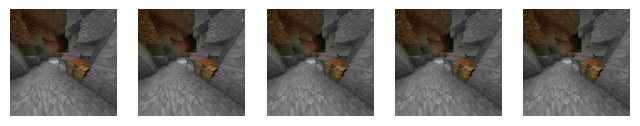

82


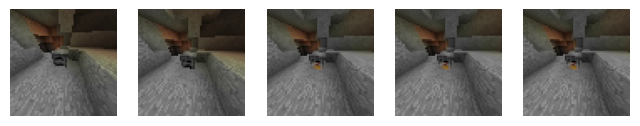

83


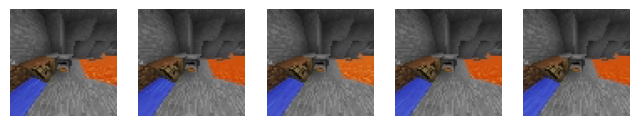

84


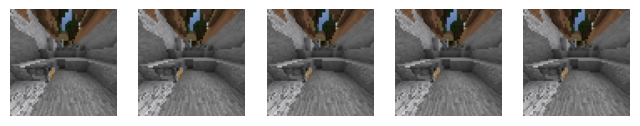

85


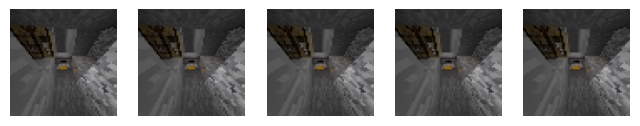

In [ ]:
# Get the cluster labels from DBSCAN
cluster_labels = dbscan.labels_

# Count the number of samples in each cluster
unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)
# Create a dictionary to store the cluster labels and their corresponding counts
cluster_counts = dict(zip(unique_labels, label_counts))
# Print the cluster labels and their counts
for label, count in cluster_counts.items():
    print(f"Cluster {label}: {count} images")

# Visualize the images of the clusters
unique_clusters = np.unique(cluster_labels)
for cluster_id in unique_clusters:
    print(cluster_id)
    
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_images = data_normalized[cluster_indices]
    # Display the first 5 images in the cluster
    fig, axs = plt.subplots(1, 5, figsize=(8, 4))
    for i, img in enumerate(cluster_images[:5]):
        reshaped_img = img.reshape((64, 64, 3))
        axs[i].imshow(reshaped_img)
        axs[i].axis('off')
    plt.show()